<a href="https://colab.research.google.com/github/CodeMind-s/Final-Year-Research-25-26J-431/blob/Crystallization-Forecasting-model-Development/crystallization_forecasting_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
# Install required packages
!pip install pmdarima openpyxl tensorflow pandas numpy scikit-learn

In [38]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [39]:
# ============================================================
# 1. DATA LOADING AND PREPROCESSING
# ============================================================

# Load data files
log_df = pd.read_excel('log_data_total.xlsx', engine='openpyxl')
weather_df = pd.read_excel('weather_data_total.xlsx', engine='openpyxl')
agg_df = pd.read_excel('aggregated_data_total.xlsx', engine='openpyxl')
prod_df = pd.read_excel('production_data_total.xlsx', engine='openpyxl')

# Rename columns for consistency
if 'date' in prod_df.columns:
    prod_df = prod_df.rename(columns={'date': 'month'})
if 'production volume' in prod_df.columns:
    prod_df = prod_df.rename(columns={'production volume': 'production_volume'})

# Process production data
prod_df['month'] = pd.to_datetime(prod_df['month'])
prod_df = prod_df.sort_values('month')
production_series = prod_df.set_index('month')['production_volume']

# Process log data
log_df['date'] = pd.to_datetime(log_df['date'])
log_df = log_df.sort_values('date')

# Define features for LSTM
features = ['water_temperature', 'lagoon', 'OR_brine_level', 'OR_bund_level',
            'IR_brine_level', 'IR_bound_level', 'East_channel', 'West_channel']

# Handle missing values
log_df[features] = log_df[features].fillna(method='ffill').fillna(method='bfill')
log_data = log_df[features].values

print(f"Data shape: {log_data.shape}")
print(f"Production data shape: {production_series.shape}")


Data shape: (953, 8)
Production data shape: (31,)


In [40]:
# ============================================================
# 2. DATA AUGMENTATION FUNCTION
# ============================================================

def augment_data(data, noise_level=0.02):
    """Add gaussian noise for data augmentation"""
    augmented = data.copy()
    noise = np.random.normal(0, noise_level, data.shape)
    augmented += noise
    return augmented

In [41]:
# ============================================================
# 3. IMPROVED DATA SCALING
# ============================================================

# Use RobustScaler to handle outliers better
scaler = RobustScaler()
log_scaled = scaler.fit_transform(log_data)

# Augment data to prevent overfitting
augmented_data = augment_data(log_scaled, noise_level=0.01)
combined_data = np.vstack([log_scaled, augmented_data])

print(f"Original data size: {log_scaled.shape}")
print(f"After augmentation: {combined_data.shape}")

Original data size: (953, 8)
After augmentation: (1906, 8)


In [42]:
# ============================================================
# 4. CREATE SEQUENCES WITH TRAIN/VAL SPLIT
# ============================================================

def create_sequences(data, lookback=30, forecast_horizon=60):
    """Create input-output sequences for LSTM"""
    X, Y = [], []
    for i in range(len(data) - lookback - forecast_horizon + 1):
        X.append(data[i:(i + lookback), :])
        Y.append(data[(i + lookback):(i + lookback + forecast_horizon), :])
    return np.array(X), np.array(Y)

lookback = 30
forecast_horizon = 60

X, Y = create_sequences(combined_data, lookback, forecast_horizon)
Y_reshaped = Y.reshape(Y.shape[0], forecast_horizon * len(features))

# Split into train and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(
    X, Y_reshaped, test_size=0.15, random_state=42, shuffle=False
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")

Training samples: 1544
Validation samples: 273


In [43]:
# ============================================================
# 5. BUILD IMPROVED LSTM MODEL WITH REGULARIZATION
# ============================================================

def build_lstm_model(lookback, n_features, forecast_horizon,
                     lstm_units=[128, 64], dropout_rate=0.3, l2_reg=0.001):
    """Build an improved LSTM model with regularization"""

    inputs = Input(shape=(lookback, n_features))

    # First Bidirectional LSTM layer
    x = Bidirectional(LSTM(
        lstm_units[0],
        return_sequences=True,
        kernel_regularizer=l2(l2_reg)
    ))(inputs)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    # Second Bidirectional LSTM layer
    x = Bidirectional(LSTM(
        lstm_units[1],
        return_sequences=False,
        kernel_regularizer=l2(l2_reg)
    ))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    # Dense layers with regularization
    x = Dense(256, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropout_rate)(x)

    # Output layer
    outputs = Dense(forecast_horizon * n_features)(x)

    model = Model(inputs=inputs, outputs=outputs)

    return model

# Build model
lstm_model = build_lstm_model(
    lookback=lookback,
    n_features=len(features),
    forecast_horizon=forecast_horizon,
    lstm_units=[128, 64],
    dropout_rate=0.3,
    l2_reg=0.001
)

# Compile with custom learning rate
optimizer = Adam(learning_rate=0.001)
lstm_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

print("\nModel Summary:")
lstm_model.summary()



Model Summary:


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 30, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 30, 256)        │       140,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 30, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 480)            │        61,920 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 434,016 (1.66 MB)

 Trainable params: 433,248 (1.65 MB)

 Non-trainable params: 768 (3.00 KB)

In [44]:
# ============================================================
# 6. CALLBACKS FOR BETTER TRAINING
# ============================================================

callbacks = [
    # Stop training when validation loss stops improving
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),

    # Reduce learning rate when validation loss plateaus
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=7,
        min_lr=1e-7,
        verbose=1
    ),

    # Save best model (using modern Keras format)
    ModelCheckpoint(
        'best_lstm_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

In [45]:
# ============================================================
# 7. TRAIN MODEL
# ============================================================

print("\nTraining LSTM Model...")
history = lstm_model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)


Training LSTM Model...
Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 3.0670 - mae: 0.8486
Epoch 1: val_loss improved from inf to 1.12812, saving model to best_lstm_model.keras
49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 192ms/step - loss: 3.0598 - mae: 0.8478 - val_loss: 1.1281 - val_mae: 0.5417 - learning_rate: 0.0010
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 1.9614 - mae: 0.7185
Epoch 2: val_loss improved from 1.12812 to 0.96436, saving model to best_lstm_model.keras
49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - loss: 1.9589 - mae: 0.7179 - val_loss: 0.9644 - val_mae: 0.5312 - learning_rate: 0.0010
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 1.4471 - mae: 0.6054
Epoch 3: val_loss improved from 0.96436 to 0.83343, saving model to best_lstm_model.keras
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 167ms/step - loss: 1.4463 - mae: 0.6051 - val_loss: 0.8334 - val_mae: 0.4996 - learning_rate: 0.0010
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 1.2306 - 

In [46]:
# ============================================================
# 8. LSTM FORECASTING FOR NEXT 60 DAYS
# ============================================================

# Use original (non-augmented) data for final prediction
last_sequence = log_scaled[-lookback:]
last_sequence = last_sequence.reshape((1, lookback, len(features)))

# Generate predictions
pred_scaled = lstm_model.predict(last_sequence, verbose=0)
pred_reshaped = pred_scaled.reshape(forecast_horizon, len(features))
pred_original = scaler.inverse_transform(pred_reshaped)

# Create forecast dataframe
lstm_forecast_df = pd.DataFrame(pred_original, columns=features)
last_date = log_df['date'].max()
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_horizon)
lstm_forecast_df['date'] = forecast_dates

print("\n" + "="*60)
print("LSTM 2-Month Daily Parameter Forecast (First 10 days):")
print("="*60)
print(lstm_forecast_df.head(10))


LSTM 2-Month Daily Parameter Forecast (First 10 days):
   water_temperature    lagoon  OR_brine_level  OR_bund_level  IR_brine_level  \
0          31.134209  2.417183        4.374363       1.207340        5.560548   
1          31.100903  2.426161        4.357915       1.170006        5.547337   
2          31.059784  2.432843        4.355603       1.144978        5.552957   
3          31.025049  2.433291        4.340166       1.128543        5.516409   
4          30.980215  2.442162        4.314387       1.119537        5.481636   
5          30.909706  2.447763        4.306045       1.114907        5.460600   
6          30.848948  2.448302        4.278719       1.108763        5.428333   
7          30.773521  2.448235        4.258896       1.115608        5.403276   
8          30.731895  2.447582        4.205858       1.124360        5.347122   
9          30.663792  2.443333        4.177379       1.137408        5.316075   

   IR_bound_level  East_channel  West_channel       

In [47]:
# ============================================================
# 9. ARIMA MODEL FOR PRODUCTION FORECAST
# ============================================================

print("\n" + "="*60)
print("Training ARIMA Model for Production Forecast...")
print("="*60)

n_periods = 6

# Fit ARIMA with seasonal component
arima_model = auto_arima(
    production_series,
    seasonal=True,
    m=12,
    trace=False,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    n_jobs=-1
)

print(f"\nBest ARIMA model: {arima_model.order} x {arima_model.seasonal_order}")

# Generate forecast
arima_forecast = arima_model.predict(n_periods=n_periods)

# Create forecast dates
last_month = production_series.index[-1]
forecast_index = pd.date_range(
    last_month + pd.offsets.MonthBegin(),
    periods=n_periods,
    freq='MS'
)
arima_forecast_df = pd.Series(arima_forecast, index=forecast_index, name='production_forecast')

print("\n" + "="*60)
print("ARIMA 6-Month Production Forecast:")
print("="*60)
print(arima_forecast_df)



Training ARIMA Model for Production Forecast...

Best ARIMA model: (0, 0, 1) x (0, 0, 0, 12)

ARIMA 6-Month Production Forecast:
2025-08-01   NaN
2025-09-01   NaN
2025-10-01   NaN
2025-11-01   NaN
2025-12-01   NaN
2026-01-01   NaN
Freq: MS, Name: production_forecast, dtype: float64


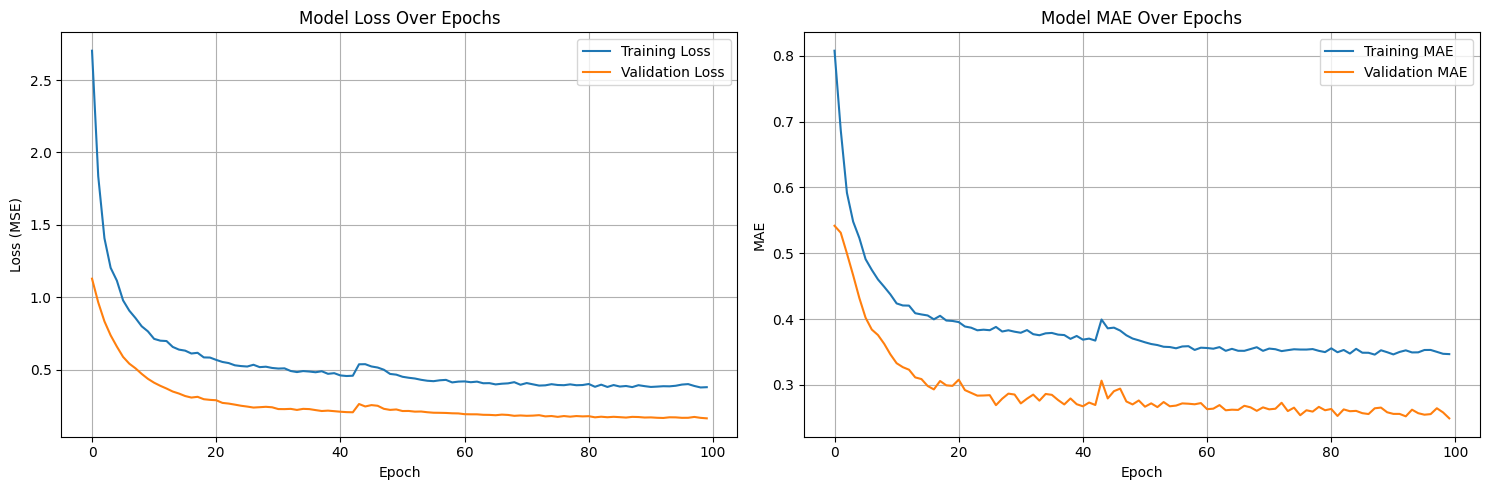

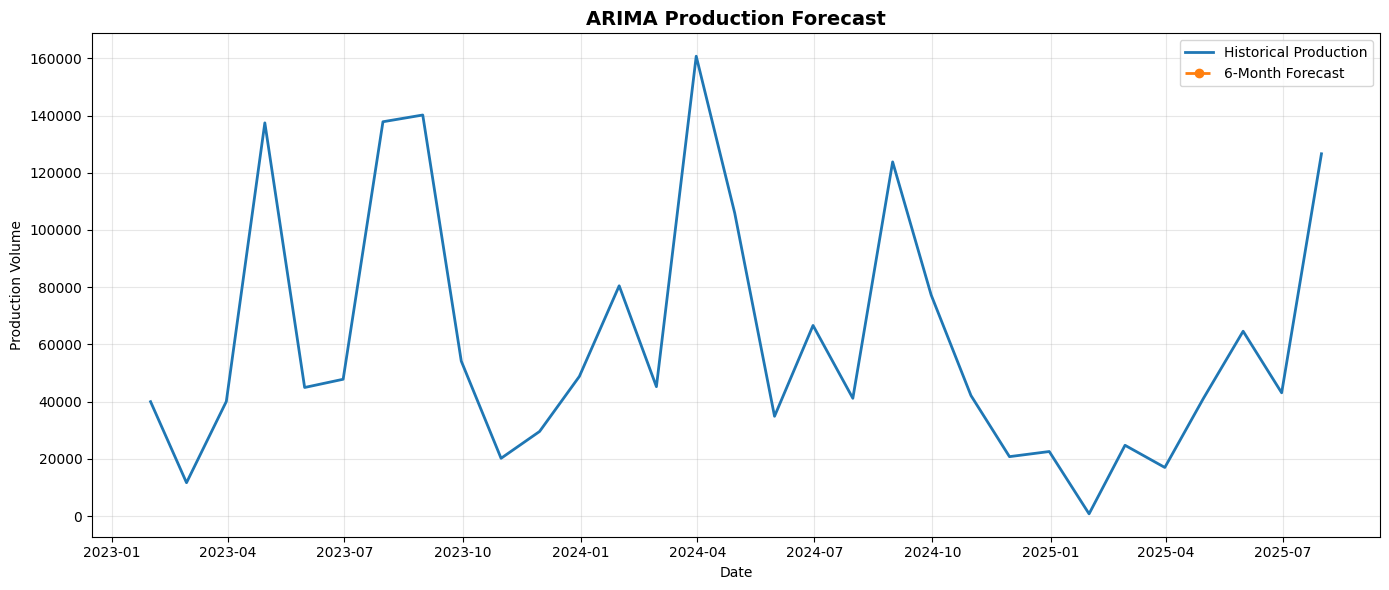

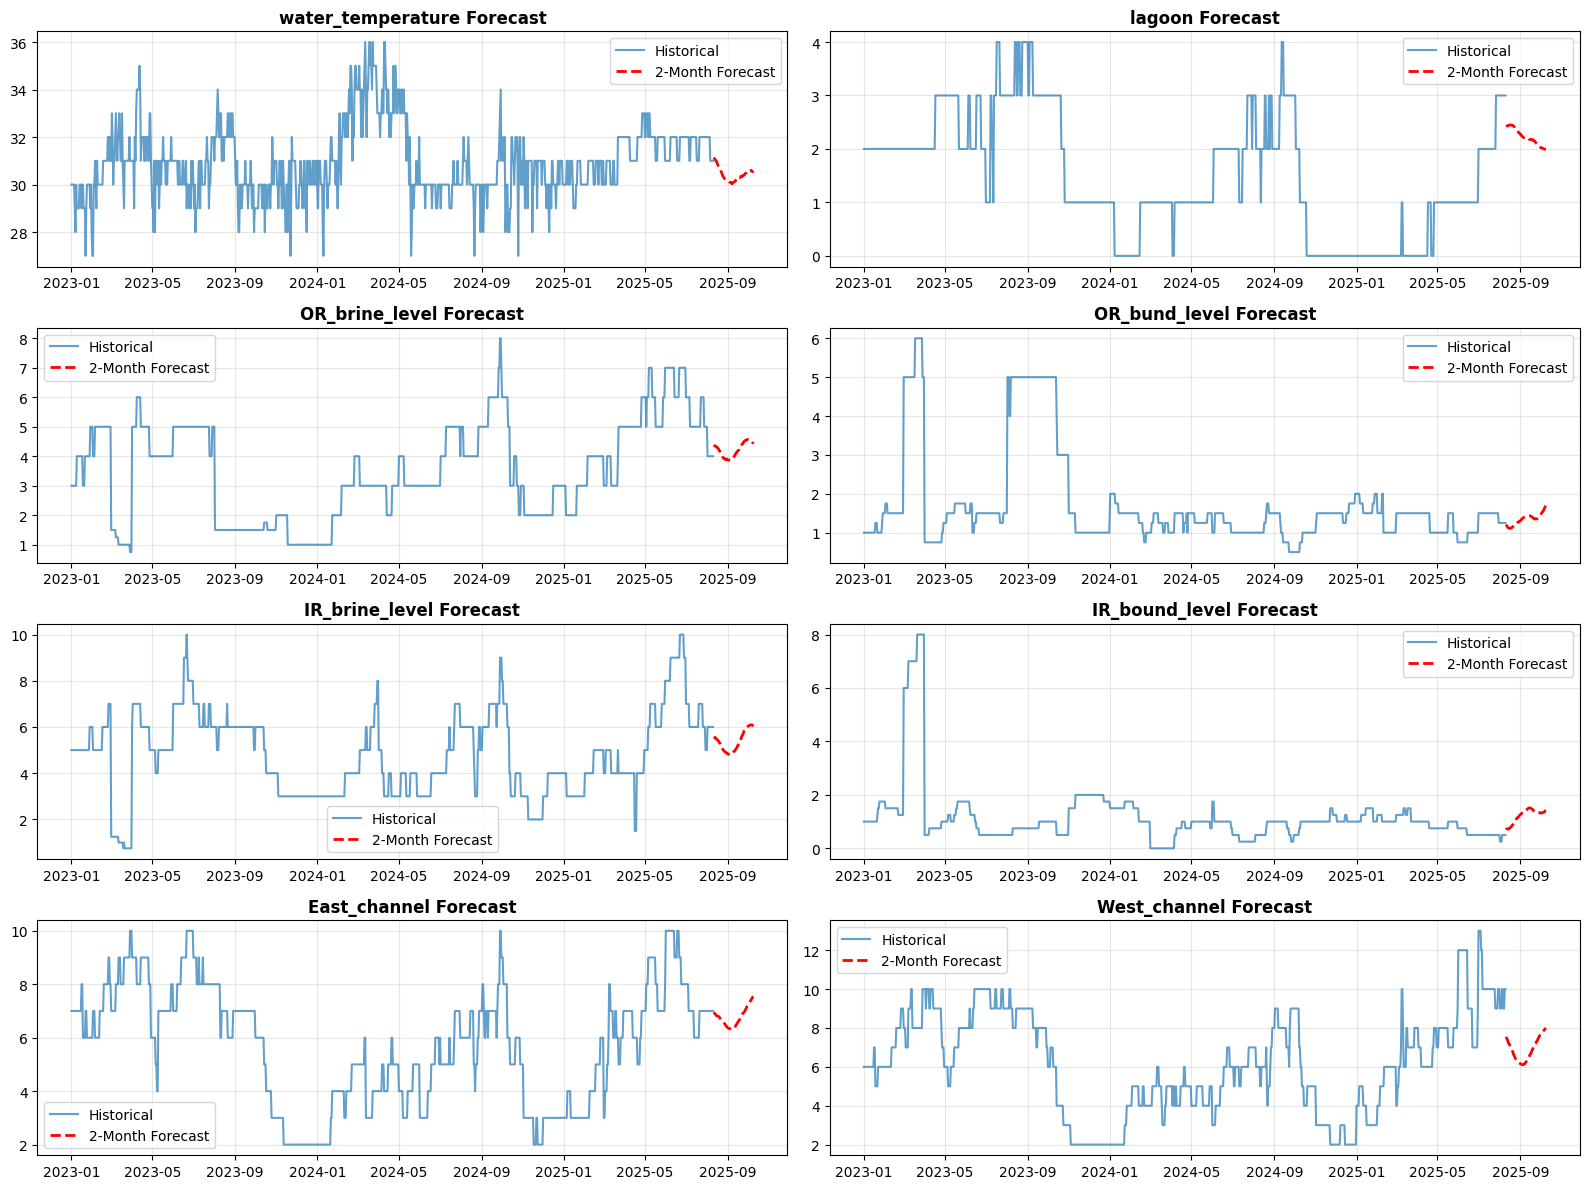

In [48]:
# ============================================================
# 10. VISUALIZATION
# ============================================================

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_title('Model Loss Over Epochs')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].legend()
axes[0].grid(True)

# MAE plot
axes[1].plot(history.history['mae'], label='Training MAE')
axes[1].plot(history.history['val_mae'], label='Validation MAE')
axes[1].set_title('Model MAE Over Epochs')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Plot production forecast
plt.figure(figsize=(14, 6))
plt.plot(production_series.index, production_series, label='Historical Production', linewidth=2)
plt.plot(arima_forecast_df.index, arima_forecast_df.values,
         label='6-Month Forecast', linestyle='--', linewidth=2, marker='o')
plt.title('ARIMA Production Forecast', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Production Volume')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot parameter forecasts
fig, axes = plt.subplots(4, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, feature in enumerate(features):
    # Historical data
    axes[idx].plot(log_df['date'], log_df[feature],
                   label='Historical', alpha=0.7, linewidth=1.5)
    # Forecast
    axes[idx].plot(lstm_forecast_df['date'], lstm_forecast_df[feature],
                   label='2-Month Forecast', linestyle='--', linewidth=2, color='red')
    axes[idx].set_title(f'{feature} Forecast', fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [49]:
# ============================================================
# 11. MODEL EVALUATION METRICS
# ============================================================

print("\n" + "="*60)
print("MODEL PERFORMANCE METRICS")
print("="*60)

# Evaluate on validation set
val_loss, val_mae = lstm_model.evaluate(X_val, Y_val, verbose=0)
print(f"Validation Loss (MSE): {val_loss:.6f}")
print(f"Validation MAE: {val_mae:.6f}")

# Calculate RMSE
val_rmse = np.sqrt(val_loss)
print(f"Validation RMSE: {val_rmse:.6f}")

print("\n" + "="*60)
print("FORECAST SUMMARY")
print("="*60)
print(f"Daily parameters forecasted for: {forecast_horizon} days")
print(f"Monthly production forecasted for: {n_periods} months")
print(f"Forecast start date (parameters): {forecast_dates[0].strftime('%Y-%m-%d')}")
print(f"Forecast end date (parameters): {forecast_dates[-1].strftime('%Y-%m-%d')}")
print(f"Forecast start month (production): {forecast_index[0].strftime('%Y-%m')}")
print(f"Forecast end month (production): {forecast_index[-1].strftime('%Y-%m')}")


MODEL PERFORMANCE METRICS
Validation Loss (MSE): 0.163006
Validation MAE: 0.249043
Validation RMSE: 0.403740

FORECAST SUMMARY
Daily parameters forecasted for: 60 days
Monthly production forecasted for: 6 months
Forecast start date (parameters): 2025-08-11
Forecast end date (parameters): 2025-10-09
Forecast start month (production): 2025-08
Forecast end month (production): 2026-01


In [50]:
# ============================================================
# 12. SAVE RESULTS
# ============================================================

# Save forecasts to Excel
with pd.ExcelWriter('forecasts_output.xlsx') as writer:
    lstm_forecast_df.to_excel(writer, sheet_name='Daily_Parameters_Forecast', index=False)
    arima_forecast_df.to_frame().to_excel(writer, sheet_name='Monthly_Production_Forecast')

print("\n✓ Forecasts saved to 'forecasts_output.xlsx'")
print("✓ Best model saved to 'best_lstm_model.keras'")
print("\nOptimization complete!")


✓ Forecasts saved to 'forecasts_output.xlsx'
✓ Best model saved to 'best_lstm_model.keras'

Optimization complete!


In [51]:
# ============================================================
# 13. HOW TO LOAD THE MODEL FOR FUTURE USE
# ============================================================

print("\n" + "="*60)
print("TO LOAD THE MODEL LATER, USE:")
print("="*60)
print("from tensorflow import keras")
print("loaded_model = keras.models.load_model('best_lstm_model.keras')")
print("="*60)


TO LOAD THE MODEL LATER, USE:
from tensorflow import keras
loaded_model = keras.models.load_model('best_lstm_model.keras')
